In [1]:
import pandas as pd
from textblob import TextBlob
import csv 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#import keras_tuner as kt
import tensorflow as tf
import sklearn as skl
from tensorflow.keras import layers
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

2024-06-04 20:54:04.528704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('Resources/airlines_reviews.csv')
df.columns

Index(['Title', 'Name', 'Review Date', 'Airline', 'Verified', 'Reviews',
       'Type of Traveller', 'Month Flown', 'Route', 'Class', 'Seat Comfort',
       'Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Value For Money', 'Overall Rating', 'Recommended'],
      dtype='object')

In [24]:
#some work on the columns #1

def column_work(df):
    
    #create new db with only the needed columns
    
    df_new = df[['Title', 'Airline', 'Reviews','Type of Traveller', 'Month Flown',
       'Route', 'Class', 'Seat Comfort',
       'Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Value For Money', 'Overall Rating', 'Recommended']]
    
    #split the month flown column into two and make the month into a number
        # first map the month names to their numbers

    num_mon = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

    df_new['Year Flown'] = df_new['Month Flown'].str.split().str[1]
    df_new['Month Flown'] = df_new['Month Flown'].str.split().str[0].map(num_mon)
    #df_new.loc[:,'Year Flown'] = df_new[:'Month Flown'].str.split().str[1]
    #df_new.loc[:, 'Month Flown'] = df_new.loc[:, 'Month Flown'].str.split().str[0].map(num_mon)

    df.head()
    df = split_to_via(df_new)
 

    return df

In [16]:
# split the route column #2
def split_to_via(df):
    # Split the text based on separators (to, via)
    split_values = df['Route'].str.split(r'(?<=\bto\b)|(?<=\bvia\b)', expand=True)
    
    # remove to and via from the split columns
    split_values = split_values.apply(lambda x: x.str.replace(r'\bto\b|\bvia\b', '', regex=True))
    
    # Create new columns and load in the split values
    df['Origin'] = split_values[0].str.strip()
    df['Destination'] = split_values[1].str.strip()
    
    # Check if the 'Via' column exists and handle multiple cities
    if 2 in split_values.columns:
        df['Via'] = split_values[2].str.replace('/', '').str.split().str[0].str.strip()
    else:
        df['Via'] = ''
    df.head()
    df = blob_function(df)
    return df

In [17]:
## text blobs #3
def blob_function(df):

    # extract the comments and ratings into a list

    titles = df['Title'].to_list()
    comments = df['Reviews'].to_list()

    # create a blank list to hold the blob

    polarities = []
    subjectivities = []

    # Analyze the sentiment of each comment 

    for comment in comments:
      blob = TextBlob(comment)
      polarity = blob.sentiment.polarity
      subjectivity = blob.sentiment.subjectivity
      polarities.append(polarity)
      subjectivities.append(subjectivity)
    
     
    # add values to new df columns

    df['Comment Polarity'] = pd.Series(polarities)
    df['Comment Subjectivity'] = pd.Series(subjectivities)

    # erase lists to hold the blob

    polarities = []
    subjectivities = []    

    # Analyze the sentiment of each title

    for title in titles:
      blob = TextBlob(title)
      polarity = blob.sentiment.polarity
      subjectivity = blob.sentiment.subjectivity
      polarities.append(polarity)
      subjectivities.append(subjectivity)

     # add values to new df columns

    df['Title Polarity'] = pd.Series(polarities)
    df['Title Subjectivity'] = pd.Series(subjectivities)

    df.head()
    df = one_hot_e(df)
    
    return df

In [18]:
# begin the one hot encoding #4

def one_hot_e (df):
    # get dummies 
    df = pd.get_dummies(df, columns = ['Class', 'Type of Traveller'])
    df = col_work_dos(df)
    df.head()
    return df

In [19]:
# more column work #5

def col_work_dos(df):
    #drop some columns
    
    df = df[['Month Flown', 'Seat Comfort',
       'Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Value For Money', 'Overall Rating', 'Recommended', 'Comment Polarity',
       'Comment Subjectivity', 'Title Polarity', 'Title Subjectivity',
       'Class_Business Class', 'Class_Economy Class', 'Class_First Class',
       'Class_Premium Economy', 'Type of Traveller_Business',
       'Type of Traveller_Couple Leisure', 'Type of Traveller_Family Leisure',
       'Type of Traveller_Solo Leisure']]
    
    
    # reformat recommended column values
    df ['Recommended'] = df['Recommended'].replace({'no':0, 'yes':1})
    
    df.head()
    return df

In [23]:
#5
df_don = column_work(df) 

/var/folders/gw/49dbrphx3bd0c4cm_7kpyb_m0000gn/T/ipykernel_23717/1335321004.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Year Flown'] = df_new['Month Flown'].str.split().str[1]
/var/folders/gw/49dbrphx3bd0c4cm_7kpyb_m0000gn/T/ipykernel_23717/1335321004.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Month Flown'] = df_new['Month Flown'].str.split().str[0].map(num_mon)
/var/folders/gw/49dbrphx3bd0c4cm_7kpyb_m0000gn/T/ipykernel_23717/3436566752.py:10: SettingWithCopyWarning: 
A va

In [25]:
df_don.head()

,Month Flown,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Comment Polarity,Comment Subjectivity,Title Polarity,Title Subjectivity,Class_Business Class,Class_Economy Class,Class_First Class,Class_Premium Economy,Type of Traveller_Business,Type of Traveller_Couple Leisure,Type of Traveller_Family Leisure,Type of Traveller_Solo Leisure
0,12,4,4,4,4,4,9,1,0.384667,0.560000,0.6,0.9,True,False,False,False,False,False,False,True
1,2,5,3,4,4,1,3,0,-0.212500,0.662500,-1.0,1.0,False,True,False,False,False,False,False,True
2,2,1,5,2,1,5,10,1,0.500000,0.750000,0.0,0.0,False,True,False,False,False,False,True,False
3,2,5,5,5,5,5,10,1,0.325496,0.565488,0.3,0.3,False,True,False,False,False,False,False,True
4,2,5,5,5,5,5,10,1,0.412500,0.537500,0.7,0.6,False,True,False,False,False,False,True,False


In [85]:
print("X_train shape:", X_train.shape)
print("X_trains_scaled shape:", X_trains_scaled.shape)


X_train shape: (6146, 20)
X_trains_scaled shape: (6146, 20)


In [80]:
df_pick.columns

Index(['Airline', 'Month Flown', 'Year Flown', 'Seat Comfort', 'Staff Service',
       'Food & Beverages', 'Inflight Entertainment', 'Value For Money',
       'Overall Rating', 'Recommended', 'Origin', 'Destination', 'Via',
       'Origin_Code', 'Destination_Code', 'Via_Code', 'Origin_City',
       'Destination_City', 'Via_City', 'Comment Polarity',
       'Comment Subjectivity', 'Title Polarity', 'Title Subjectivity',
       'Class_Business Class', 'Class_Economy Class', 'Class_First Class',
       'Class_Premium Economy', 'Type of Traveller_Business',
       'Type of Traveller_Couple Leisure', 'Type of Traveller_Family Leisure',
       'Type of Traveller_Solo Leisure'],
      dtype='object')

In [86]:
# pickle winner
    
#begin the machine

to_drop = ['Airline', 'Origin', 'Destination', 'Via', 'Origin_Code', 'Destination_Code', 'Via_Code', 'Origin_City',
      'Destination_City', 'Via_City']
df = df_pick.drop(to_drop, axis=1)
X = df_pick.drop('Recommended', axis=1)
y = df_pick['Recommended']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = 43)
X_scaler = skl.preprocessing.StandardScaler()
X_scaler.fit(X_train)
X_trains_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
    
nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=3, activation="relu", input_dim=20))

nn_model.add(tf.keras.layers.Dense(units=5, activation="sigmoid"))

#nn_model.add(tf.keras.layers.Dense(units=22, activation="relu"))

nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()

# Compile the model and train over more than 100 epochs
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
fit_model = nn_model.fit(X_trains_scaled, y_train, epochs=150)

# Train the model
fit_model = nn_model.fit(X_trains_scaled, y_train, epochs=150)

# Evaluate the model on the scaled test data
loss, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the scaled test data
predictions = nn_model.predict(X_test_scaled)
        

/Users/mother/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 3)              │            63 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5331 - loss: 0.6888
Epoch 2/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7837 - loss: 0.6349
Epoch 3/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9061 - loss: 0.4983
Epoch 4/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9320 - loss: 0.3425
Epoch 5/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9357 - loss: 0.2638
Epoch 6/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9419 - loss: 0.2208
Epoch 7/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9385 - loss: 0.2080
Epoch 8/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1942
Epoch 9/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - loss: 0.1861
Epoch 10/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9465 - loss: 0.1773
Epoch 11/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9439 - loss: 0.1714
Epoch 12/150
193/193 ━━━━━━━━━━━━━━━━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


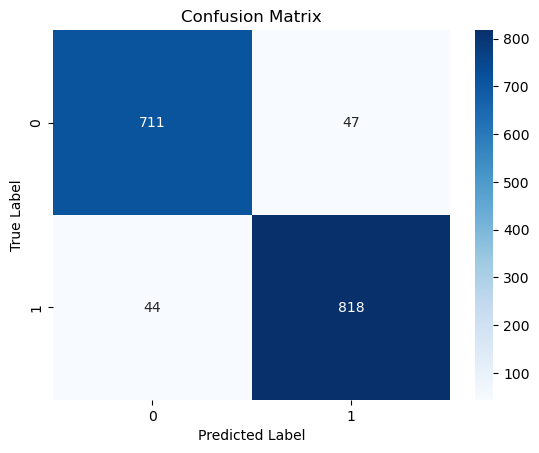

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
predictions = nn_model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [73]:
df_pick = pickle.load(open('df.pkl','rb'))

In [34]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = nn_model.predict(X_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Generate the classification report
report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(report)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       758
           1       0.95      0.95      0.95       862

    accuracy                           0.94      1620
   macro avg       0.94      0.94      0.94      1620
weighted avg       0.94      0.94      0.94      1620



51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


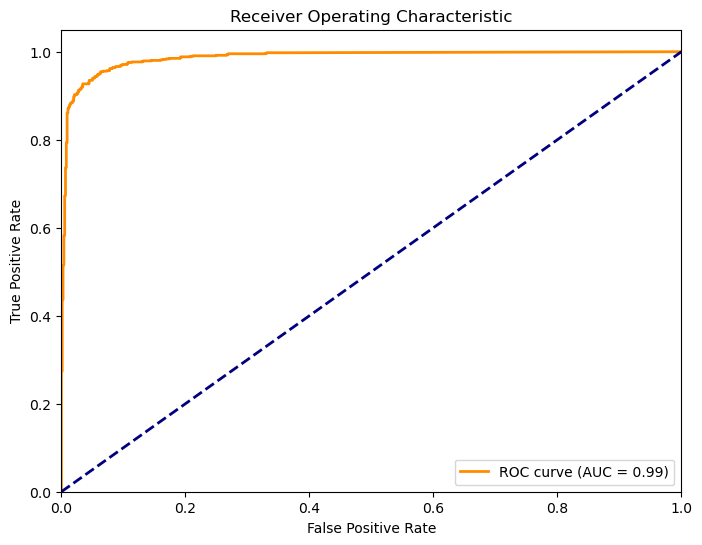

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = nn_model.predict(X_test_scaled)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#fill in feature name from processed but not machined data

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of a specific feature
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='feature_name', kde=True)
plt.title('Distribution of Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()

# Pair plot to visualize relationships between features
sns.pairplot(df, hue='target_variable')
plt.show()